# Task 1: Next Word Prediction Model
## Objective: To understand the basics of sequential modelling and RNNs (Recurrent Neural Networks).

## Step 1: Data preparation
### ● Task: Use a simple set of text data (e.g. tweets, dialogue from films) to create pairs of word sequences, where each pair consists of a string of words followed by a word.
### ● Hint: You can use tokenisation () of the words and convert them into a numerical representation.

In [309]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch import optim
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gzdro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gzdro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [310]:
text_data = pd.read_csv("next_word_prediction_data_base.txt", header= None, delimiter = "\d") # load data
text_data

C:\Users\gzdro\AppData\Local\Temp\ipykernel_16420\902822204.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  text_data = pd.read_csv("next_word_prediction_data_base.txt", header= None, delimiter = "\d") # load data


,0
0,Embrace the beauty of every sunrise\t it's a f...
1,Embrace challenges\t they are the stepping sto...
2,Embrace the rhythm of life and let it dance th...
3,"Embrace kindness, for it has the power to chan..."
4,"Embrace the journey, for it leads to the desti..."
...,...
2527,"Believe in yourself, and your grace will be th..."
2528,"Believe in yourself, and your gratitude will b..."
2529,"Believe in yourself, for your kindness will be..."
2530,"Believe in yourself, and your joy will be the ..."


In [311]:
text_data.columns = ['Dialog'] # change column name 
text_data

,Dialog
0,Embrace the beauty of every sunrise\t it's a f...
1,Embrace challenges\t they are the stepping sto...
2,Embrace the rhythm of life and let it dance th...
3,"Embrace kindness, for it has the power to chan..."
4,"Embrace the journey, for it leads to the desti..."
...,...
2527,"Believe in yourself, and your grace will be th..."
2528,"Believe in yourself, and your gratitude will b..."
2529,"Believe in yourself, for your kindness will be..."
2530,"Believe in yourself, and your joy will be the ..."


In [312]:
dialog_list = text_data['Dialog'].tolist()
# dialog_list = dialog_list[:2000]
len(dialog_list)

2532

In [313]:
# Dictionaries
word_to_index = {}
index_to_word = {}
word_index = 0 

def preprocess_text(text):
    '''
    Word preparation function. Tokenization.
    '''
    global word_index

    text = text.translate(str.maketrans("", "", string.punctuation)) # remove special characters
    text = text.lower() # change to lower letters
    
    tokens = word_tokenize(text) # word tokenization
    
    stop_words = set(stopwords.words('english')) # remove stopwords 
    tokens = [token for token in tokens if token not in stop_words] 

    # dictionary updates
    for token in tokens:
        if token not in word_to_index:
            word_to_index[token] = word_index
            index_to_word[word_index] = token
            word_index += 1
    
    return tokens

In [314]:
# pairs of word sequences
sequences = [preprocess_text(sentence) for sentence in dialog_list]

In [315]:
# split data into test and training data
train_sequences, test_sequences = train_test_split(sequences, test_size = 0.25, random_state = 32)

In [316]:
class SeqWordDataset(Dataset):
    def __init__(self, sequences, word_to_index, max_seq_length=None):
        self.sequences = sequences
        self.word_to_index = word_to_index
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        tokens = self.sequences[idx]
        if self.max_seq_length is not None:
            tokens = tokens[:self.max_seq_length]
        # checking if the token is not empty
        if len(tokens) > 0:
            input_sequence = [self.word_to_index.get(token, 0) for token in tokens[:-1]]
            target_word = self.word_to_index.get(tokens[-1], 0)
        else:
            input_sequence = [0]
            target_word = 0

        return torch.tensor(input_sequence, dtype = torch.long), torch.tensor(target_word, dtype = torch.long)

In [317]:
def padding_sequences(batch):
    # tokens should be of similar length
    input_sequences, target_words = zip(*batch)
    padded_input_sequences = pad_sequence(input_sequences, batch_first=True, padding_value=0)
    padded_target_words = torch.tensor(target_words, dtype=torch.long)
    return padded_input_sequences, padded_target_words

In [318]:
max_seq_length = 8
train_dataset = SeqWordDataset(train_sequences, word_to_index, max_seq_length=max_seq_length)
test_dataset = SeqWordDataset(test_sequences, word_to_index, max_seq_length=max_seq_length)

In [319]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn = padding_sequences)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn = padding_sequences)

## Step 2: Building an RNN Model
### ● Task: Build a simple RNN model in PyTorch that will predict the next word based on the given word sequence.
### ● Hint: Use torch.nn.RNN or torch.nn.LSTM to create the model.

In [325]:
class ModelLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(ModelLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True)
        self.layer_norm = nn.BatchNorm1d(hidden_dim * 2)
        self.fc1 = nn.Linear(hidden_dim * 2, vocab_size)
        self.fc2 = nn.Linear(vocab_size, vocab_size)
        self.activ = nn.ELU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        lstmm, _ = self.lstm(embedded)
        layers = self.layer_norm(lstmm.permute(0, 2, 1).contiguous()).permute(0, 2, 1)
        activation = self.activ(torch.mean(layers, dim=1).float())
        fc1_linear = self.fc1(activation)
        fc2_linear = self.fc2(fc1_linear) 
        out = self.log_softmax(fc2_linear)
        return out

In [326]:
vocab_size = len(word_to_index)
embedding_dim = 500
hidden_dim = 500
num_layers = 2

model = ModelLSTM(vocab_size, embedding_dim, hidden_dim, num_layers)

## Step 3: Training and Testing
### ● Task: Train the model on the prepared data and then test its ability to predict the next words in new sequences.
### ● Hint: Monitor loss during training and adjust parameters, such as the number of training epochs or the size of the hidden layer, to improve performance.

In [327]:
lr = 0.001
l2 = 1e-5
opt = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=l2)
scheduler = StepLR(opt, step_size = 5, gamma = 0.5)
loss_func = nn.CrossEntropyLoss()

In [328]:
def trainer(model, train_loader, loss_func, opt, epochs, scheduler=None, max_seq_length=None):
    '''
    A function for training the model.
    '''
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for x, y in train_loader:
            if max_seq_length is not None:
                x = x[:, :max_seq_length]
            opt.zero_grad()

            # prediction
            pred = model(x)

            # loss function
            loss = loss_func(pred, y.long())
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)

            # backprop and optimalization
            loss.backward()
            opt.step()

            running_loss += loss.item()

            # accuracy
            _, predicted = torch.max(pred.data, 1)
            total_samples += y.size(0)
            correct_predictions += (predicted == y).sum().item()

        train_losses.append(running_loss / len(train_loader))
        accuracy = correct_predictions / total_samples
        train_accuracies.append(accuracy)
        if scheduler is not None:
            scheduler.step()

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy * 100:.2f}%')

    return train_losses, train_accuracies

In [330]:
epochs = 15
train_losses, train_accuracies = trainer(model, train_loader, loss_func, opt, epochs = epochs, scheduler=scheduler, max_seq_length=max_seq_length)

Epoch 1/15, Train Loss: 4.5239, Accuracy: 30.49%
Epoch 2/15, Train Loss: 2.3081, Accuracy: 53.34%
Epoch 3/15, Train Loss: 1.2569, Accuracy: 71.77%
Epoch 4/15, Train Loss: 0.8624, Accuracy: 81.46%
Epoch 5/15, Train Loss: 0.5964, Accuracy: 86.89%
Epoch 6/15, Train Loss: 0.2867, Accuracy: 92.89%
Epoch 7/15, Train Loss: 0.1592, Accuracy: 95.37%
Epoch 8/15, Train Loss: 0.1349, Accuracy: 96.05%
Epoch 9/15, Train Loss: 0.1288, Accuracy: 96.16%
Epoch 10/15, Train Loss: 0.1300, Accuracy: 96.47%
Epoch 11/15, Train Loss: 0.0919, Accuracy: 96.58%
Epoch 12/15, Train Loss: 0.0821, Accuracy: 96.58%
Epoch 13/15, Train Loss: 0.0830, Accuracy: 96.37%
Epoch 14/15, Train Loss: 0.0816, Accuracy: 96.26%
Epoch 15/15, Train Loss: 0.0829, Accuracy: 96.26%


In [331]:
def tester(model, data_loader, loss_func, max_seq_length=None):
    '''
    A function for testing the model.
    '''
    model.eval()
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    

    with torch.no_grad():
        for x, y in data_loader:
            if max_seq_length is not None:
                x = x[:, :max_seq_length]

            # prediction
            pred = model(x)

            # loss function
            loss = loss_func(pred, y)
            test_loss += loss.item()

            # accuracy 
            _, predicted = torch.max(pred.data, 1)
            total_samples += y.size(0)
            correct_predictions += (predicted == y).sum().item()

    test_losses = test_loss / len(data_loader)
    test_accuracy = correct_predictions / total_samples

    print(f'Test Loss: {test_losses:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')

    return test_losses, test_accuracy

In [332]:
test_losses, test_accuracy = tester(model, test_loader, loss_func, max_seq_length=max_seq_length)

Test Loss: 4.1007, Test Accuracy: 56.24%


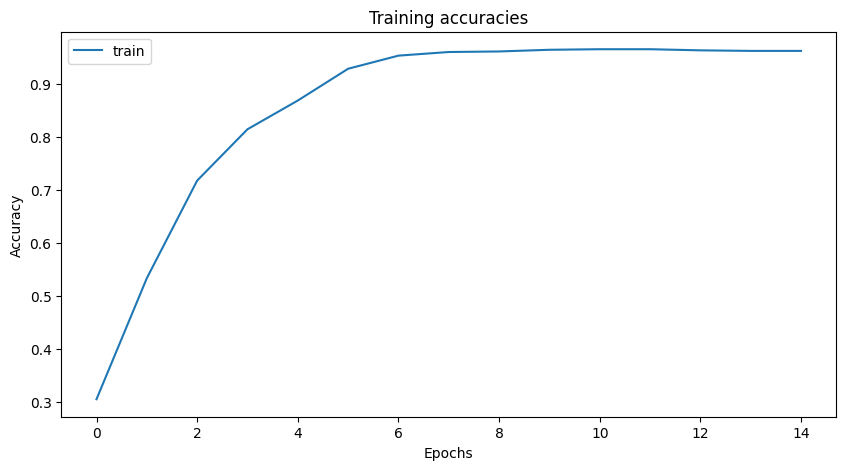

In [333]:
# accuracy's plot
plt.figure(figsize=(10,5))
plt.title("Training accuracies")
plt.plot(train_accuracies, label="train")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

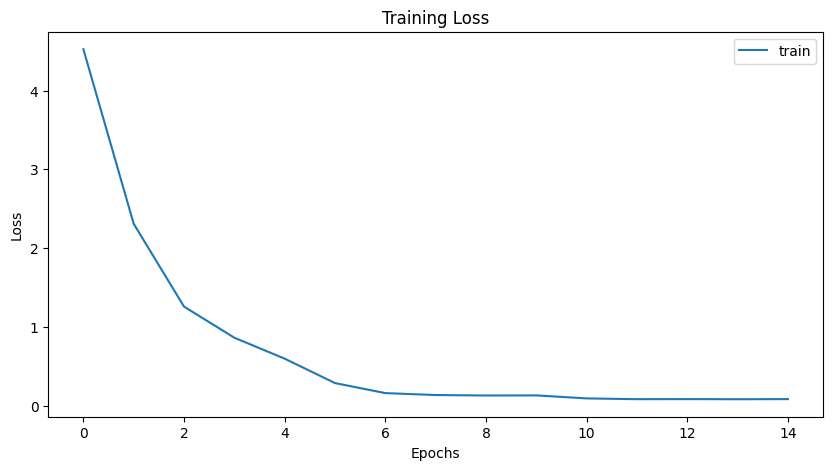

In [334]:
# loss function's plot 
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(train_losses, label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()